In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import itertools
import numpy as np
from scipy import stats
from os import listdir
 
sns.set(style="ticks", font_scale=1.3, font="Arial")

# Global variables for plotting

In [2]:
CONDS = [
    "probable", "improbable", "impossible", "inconceivable", "inconceivable_syntactic"
]
LABELS = [
    "probable", "improbable", "impossible", "nonsense"
]
PRETTY_COND_MAP = {
    "probable": "Probable",
    "improbable": "Improbable",
    "impossible": "Impossible",
    "inconceivable": "Inconceivable",
    "inconceivable_syntactic": "Inconceivable-Syntax" 
}
PRETTY_CONDS = [PRETTY_COND_MAP[c] for c in CONDS]
PRETTY_LABELS = [l.capitalize() for l in LABELS]

NEURAL_MODELS = ["gpt2", "gpt2-medium", "gpt2-xl", "meta-llama/meta-llama-3-8b", "meta-llama/meta-llama-3-70b"]
MODELS = ["infinigram"] + NEURAL_MODELS
PRETTY_MODEL_MAP = {
    "infinigram": "$\\infty$-gram",
    "gpt2": "GPT-2 (124M)",
    "gpt2-medium": "GPT-2 Med (355M)",
    "gpt2-xl": "GPT-2 XL (1.5B)",
    "meta-llama/meta-llama-3-8b": "Llama-3 (8B)",
    "meta-llama/meta-llama-3-70b": "Llama-3 (70B)"
}
PRETTY_MODELS = [PRETTY_MODEL_MAP[m] for m in MODELS]

darkblue, lightblue = "#6E7CB9FF", "#7BBCD5FF"
darkred, lightred = "#ef435e", "#f79f99"
darkorange, lightorange = "#F9AB0EFF", "#FBC559FF"
COND_PAL = {
    "probable": darkblue,
    "improbable": lightblue,
    "impossible": darkorange,
    "inconceivable": darkred,
    "inconceivable_syntactic": lightred,
}

NGRAM_DIR = "../data/exp2_model_surprisal/infinigram"
NGRAM_INDEX = "v4_dolma-v1_7_llama" #"v4_pileval_gpt2"
SURPRISAL_DIR = "../data/exp2_model_surprisal/surprisals"

def get_steps_tokens(revision):
    if revision is None:
        return None, None
    step_str, token_str = revision.split("-")
    steps = int(step_str.replace("step", ""))
    tokens = int(token_str.replace("tokens", "").replace("B", ""))
    return steps, tokens

def render(outpath=None):
    if outpath is not None:
        plt.savefig(f"../figures/{outpath}", dpi=300, bbox_inches="tight")

# Experiment 1: Modal classification task

In [3]:
# Helper function for labeling whether a response matches the underlying condition.
def is_correct(response, condition):
    condition_coarse = condition.split("_")[0]
    if response == condition_coarse:
        return True
    elif response == "nonsense" and condition_coarse == "inconceivable":
        return True
    else:
        return False

exp1 = pd.read_csv("../data/exp1_human_classification/trial_data.csv")
exp1["response_correct"] = exp1.apply(
    lambda r: is_correct(r.response_label, r.condition),
    axis=1
)
print(f"Experiment 1: {exp1.subject_id.nunique()} unique subjects")

Experiment 1: 149 unique subjects


## Figure 1a

condition
impossible       0.633550
improbable       0.554059
inconceivable    0.829567
probable         0.963888
Name: response_correct, dtype: float64

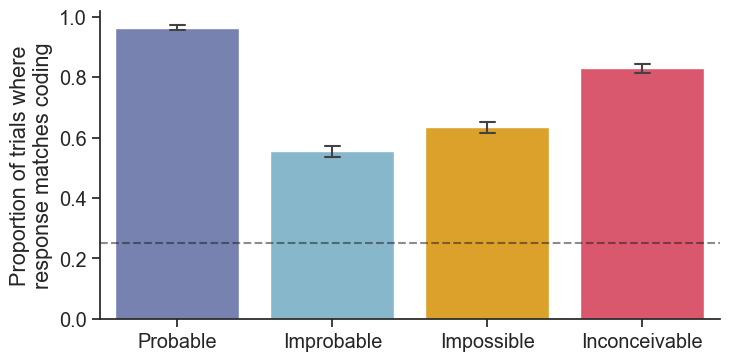

In [4]:
ax = sns.barplot(
    data=exp1, 
    x="condition", 
    y="response_correct", 
    hue="condition",
    legend=False,
    order=CONDS[:-1], 
    palette=COND_PAL,
    capsize=0.1,
    err_kws=dict(linewidth=1.5)
)
ax.set_xticks(range(len(CONDS)-1))
ax.set_xticklabels([c.replace(" ", "\n") for c in PRETTY_CONDS[:-1]])
ax.set_xlabel("")
ax.set_ylabel("Proportion of trials where\nresponse matches coding")
ax.axhline(0.25, linestyle="--", color="k", alpha=0.5)
plt.gcf().set_size_inches(8,4)
sns.despine()
render("fig1a_exp1_proportion_correct.pdf")
exp1.groupby("condition").response_correct.mean()

## Figure 1b

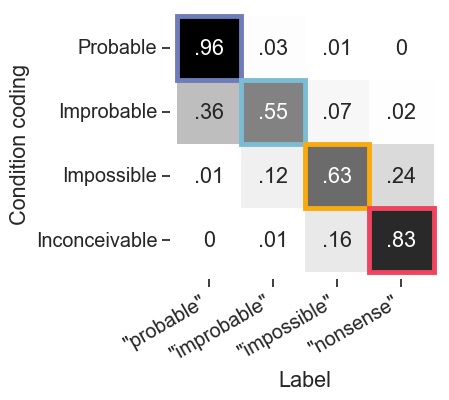

In [5]:
confusion = np.ones((len(CONDS[:-1]), len(LABELS)))
annot = []
for i, cond in enumerate(CONDS[:-1]):
    cond_rows = exp1[exp1.condition==cond]
    annot_row = []
    for j, label in enumerate(LABELS):
        # get rows with this ground-truth condition, and this predicted label
        rows = cond_rows[cond_rows.response_label==label] 
        confusion[i][j] = len(rows) / len(cond_rows)
        s = f"{confusion[i][j]:.2f}"
        if s == "0.00":
            s = "0"
        elif s == "1.00":
            s = "1"
        elif s.startswith("0."):
            s = s[1:]
        annot_row.append(s)
    annot.append(annot_row)

from matplotlib.patches import Rectangle
ax = sns.heatmap(confusion, annot=annot, cmap="Greys", fmt="", square=True, cbar=False)
# Add squares for "accuracy".
annot_coords = {
    "probable": (0, 0),
    "improbable": (1, 1),
    "impossible": (2,2),
    "inconceivable": (3,3)
}
for cond, coords in annot_coords.items():
    ax.add_patch(Rectangle(coords, 1, 1, fill=False, edgecolor=COND_PAL[cond], lw=3.5))
lo, hi = ax.get_xlim()
ax.set_xlim(lo-0.1, hi+0.1)
lo, hi = ax.get_ylim()
ax.set_ylim(lo+0.1, hi-0.1)
    
ax.set_yticklabels(PRETTY_CONDS[:-1], rotation=0)
ax.set_ylabel("Condition coding")
ax.set_xticklabels(['"probable"', '"improbable"', '"impossible"', '"nonsense"'], rotation=30, ha="right")
ax.set_xlabel("Label")
plt.gcf().set_size_inches(3.5, 3.5)
render("fig1b_exp1_confusion_matrix.pdf")

# Experiment 2: Decoding modal categories from probabilities

## Step 1. Read data from neural models

In [3]:
def read_neural_model_data():
    model_df = pd.concat([
        pd.read_csv(f"{SURPRISAL_DIR}/summary_{model.split('/')[-1].lower()}.csv")
        for model in NEURAL_MODELS
    ])
    model_df["model"] = model_df["model"].apply(lambda m: m.lower())
    return model_df

model_df = read_neural_model_data()
model_df.head()

,item_id,eval_prefix,condition,continuation,continuation_sum_logprob,continuation_mean_logprob,model
0,0,He baked a cake inside,probable,an oven.,-7.678192,-2.559397,gpt2
1,0,He baked a cake inside,improbable,an airfryer.,-24.097740,-4.016290,gpt2
2,0,He baked a cake inside,impossible,a freezer.,-9.375153,-3.125051,gpt2
3,0,He baked a cake inside,inconceivable,a sigh.,-15.744316,-5.248105,gpt2
4,0,He baked a cake inside,inconceivable_syntactic,grasp.,-18.422318,-9.211159,gpt2


## Step 2a. Read data from infini-gram model and apply smoothing

In [4]:
def laplace_smoothing(df, vocab_size=50257):
    print(f"Performing Laplace smoothing with |V|={vocab_size}")
    df["prob_smoothed"] = df.apply(
        lambda r: (r.cont_cnt + 1) / (r.prompt_cnt + vocab_size),
        axis=1
    )
    df["logprob_smoothed"] = np.log(df.prob_smoothed)
    return df

def aggregate_logprobs(df):
    g = df.groupby(["item_id", "condition", "continuation"])
    sums = g["logprob_smoothed"].sum().rename("continuation_sum_logprob").to_frame()
    means = g["logprob_smoothed"].mean().rename("continuation_mean_logprob").to_frame()
    agg = sums.join(means).reset_index()
    return agg

def read_ngram_data(**kwargs):
    ngram_df = pd.read_csv(f"{NGRAM_DIR}/probs_{NGRAM_INDEX}.csv")
    ngram_df = laplace_smoothing(ngram_df, **kwargs)
    ngram_probs_agg = aggregate_logprobs(ngram_df)
    ngram_probs_agg["model"] = "infinigram"
    return ngram_probs_agg

ngram_df = read_ngram_data(vocab_size=50257 if "gpt2" in NGRAM_INDEX else 32000)
ngram_df.head()

Performing Laplace smoothing with |V|=32000


,item_id,condition,continuation,continuation_sum_logprob,continuation_mean_logprob,model
0,0,impossible,a freezer,-27.314811,-9.104937,infinigram
1,0,improbable,an airfryer,-49.383424,-9.876685,infinigram
2,0,inconceivable,a sigh,-29.511879,-9.837293,infinigram
3,0,inconceivable_syntactic,grasp,-10.374116,-10.374116,infinigram
4,0,probable,an oven,-28.636348,-9.545449,infinigram


In [5]:
# Combine neural and ngram probability data.
full_model_df = pd.concat([model_df, ngram_df]).reset_index().drop(columns=["index"])

# Add surprisal metric.
for metric in ["sum", "mean"]:
    full_model_df[f"continuation_{metric}_surprisal"] = -1 * full_model_df[f"continuation_{metric}_logprob"]
    
full_model_df.head()

,item_id,eval_prefix,condition,continuation,continuation_sum_logprob,continuation_mean_logprob,model,continuation_sum_surprisal,continuation_mean_surprisal
0,0,He baked a cake inside,probable,an oven.,-7.678192,-2.559397,gpt2,7.678192,2.559397
1,0,He baked a cake inside,improbable,an airfryer.,-24.097740,-4.016290,gpt2,24.097740,4.016290
2,0,He baked a cake inside,impossible,a freezer.,-9.375153,-3.125051,gpt2,9.375153,3.125051
3,0,He baked a cake inside,inconceivable,a sigh.,-15.744316,-5.248105,gpt2,15.744316,5.248105
4,0,He baked a cake inside,inconceivable_syntactic,grasp.,-18.422318,-9.211159,gpt2,18.422318,9.211159


## Step 3. Read ngram count data

In [6]:
ngram_counts = pd.read_csv(f"{NGRAM_DIR}/counts_{NGRAM_INDEX}.csv") 
ngram_counts["log_count"] = np.log(ngram_counts["count"])
ngram_counts.head()

,item_id,condition,continuation,approx,count,latency,token_ids,tokens,n_tokens,log_count
0,0,probable,an oven,False,1937872,18.480539,"[385, 288, 854]","['▁an', '▁o', 'ven']",3,14.477101
1,0,improbable,an airfryer,False,6793,2.508879,"[385, 4799, 29888, 719, 261]","['▁an', '▁air', 'f', 'ry', 'er']",5,8.823648
2,0,impossible,a freezer,False,897337,12.892246,"[263, 3889, 3298]","['▁a', '▁free', 'zer']",3,13.707187
3,0,inconceivable,a sigh,False,2472962,12.351274,"[263, 269, 1141]","['▁a', '▁s', 'igh']",3,14.720927
4,0,inconceivable_syntactic,grasp,False,22451743,16.025305,[25274],['▁grasp'],1,16.926879


In [7]:
# Combine surprisal and ngram frequency data.
index = ["item_id", "condition"]
ngram_counts = ngram_counts.set_index(index)[["count", "log_count"]]
full_model_df_with_counts = full_model_df.set_index(index).join(
    ngram_counts, 
    on=index
).reset_index()
full_model_df_with_counts.to_csv(f"../data/exp2_model_surprisal/surprisal_ngram_data.csv", index=False)
full_model_df_with_counts.head()

,item_id,condition,eval_prefix,continuation,continuation_sum_logprob,continuation_mean_logprob,model,continuation_sum_surprisal,continuation_mean_surprisal,count,log_count
0,0,probable,He baked a cake inside,an oven.,-7.678192,-2.559397,gpt2,7.678192,2.559397,1937872,14.477101
1,0,improbable,He baked a cake inside,an airfryer.,-24.097740,-4.016290,gpt2,24.097740,4.016290,6793,8.823648
2,0,impossible,He baked a cake inside,a freezer.,-9.375153,-3.125051,gpt2,9.375153,3.125051,897337,13.707187
3,0,inconceivable,He baked a cake inside,a sigh.,-15.744316,-5.248105,gpt2,15.744316,5.248105,2472962,14.720927
4,0,inconceivable_syntactic,He baked a cake inside,grasp.,-18.422318,-9.211159,gpt2,18.422318,9.211159,22451743,16.926879


## Step 4. Plot!

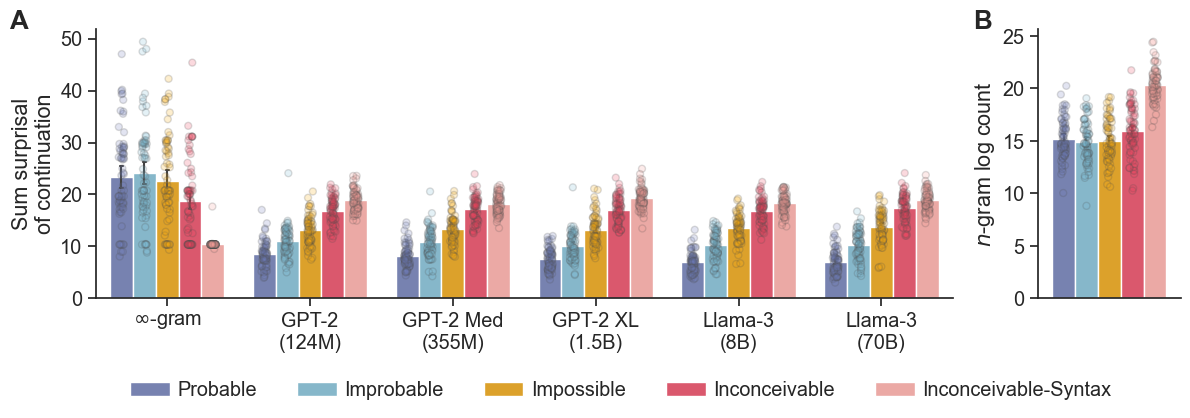

<Figure size 640x480 with 0 Axes>

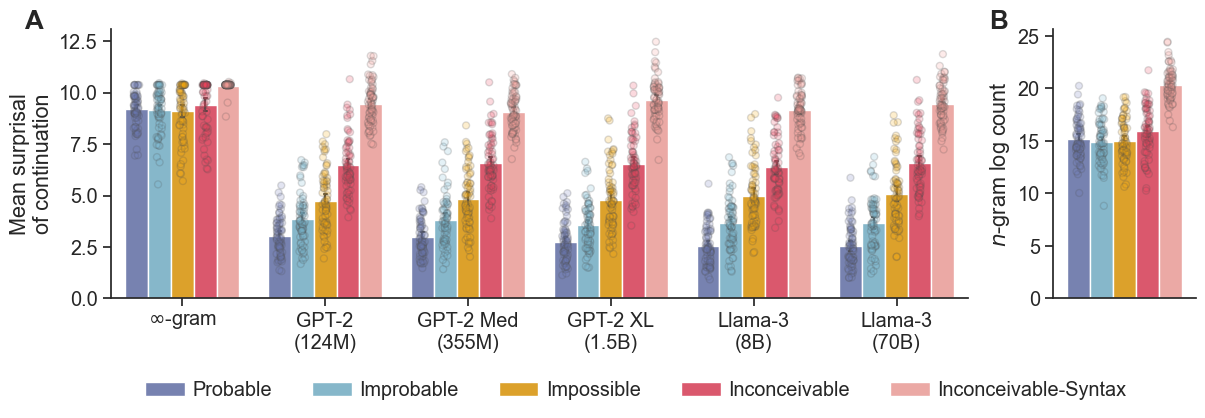

<Figure size 640x480 with 0 Axes>

In [8]:
def plot_surprisals_freqs(df, ngrams, metric="sum", freq_stat="log_count"):
    # Set up subplots.
    fig, axes = plt.subplots(
        nrows=1, ncols=2, 
        sharex=False, sharey=False, 
        figsize=(14,3.5), 
        gridspec_kw={'width_ratios': [len(MODELS), 1]}
    )
    ax0, ax1 = axes
    
    # Common keywords for stripplots and barplots.
    strip_kws = dict(alpha=0.2, linewidth=1, dodge=True, legend=False)
    bar_kws = dict(capsize=0.1, err_kws=dict(linewidth=1.5))
    
    # Plot surprisals across conditions on the first axis.
    surp_kws = dict(
        data=df, 
        x="model", 
        y=f"continuation_{metric}_surprisal",
        order=MODELS,
        hue="condition", 
        hue_order=CONDS,
        palette=COND_PAL,
        ax=ax0
    )
    ax0 = sns.barplot(**surp_kws, **bar_kws)
    ax0 = sns.stripplot(**surp_kws, **strip_kws)
    ax0.set_ylabel(f"{metric.capitalize()} surprisal\nof continuation")
    ax0.set_xlabel("")
    model_labels = []
    for i, m in enumerate(PRETTY_MODELS):
        if len(m.split()) > 1:
            new_m = " ".join(m.split(" ")[:-1]) + "\n" + m.split(" ")[-1]
            model_labels.append(new_m)
        else:
            model_labels.append(m)
    ax0.set_xticks(range(len(MODELS)), model_labels)
    ax0.get_legend().remove()
    
    # Plot ngram frequencies across conditions on the second axis.
    freq_kws = dict(
        data=ngrams, 
        y=freq_stat, 
        hue="condition", 
        hue_order=CONDS,
        palette=COND_PAL,
        ax=ax1
    )
    ax1 = sns.barplot(**freq_kws, **bar_kws)
    ax1 = sns.stripplot(**freq_kws, **strip_kws)

    ax1.set_xlabel("")
    ax1.set_ylabel("$n$-gram log count")
    ax1.set_xticks([])
    ax1.get_legend().remove()
    
    handles, labels = ax0.get_legend_handles_labels()
    labels = [PRETTY_COND_MAP[l] for l in labels]
    plt.figlegend(
        handles,
        labels, 
        loc="upper center", bbox_to_anchor=(0.5, -0.075), 
        ncol=len(CONDS),
        handletextpad=0.4,
        frameon=False
    )
    plt.subplots_adjust(wspace=0.17)
    sns.despine()
    
    # Add annotations of A and B.
    ax0.text(-0.1, 1, "A", size="large", fontweight="bold", transform=ax0.transAxes)
    ax1.text(-0.45, 1, "B", size="large", fontweight="bold", transform=ax1.transAxes)
    
for metric in ["sum", "mean"]:
    plot_surprisals_freqs(full_model_df, ngram_counts, metric=metric)
    render(f"exp2_surprisal_{metric}.pdf")
    plt.show()
    plt.clf()

## Training time analyses

In [9]:
olmo_files = [
    f for f in listdir(SURPRISAL_DIR) if f.startswith("summary") and "olmo" in f
]
olmo_df = pd.concat([pd.read_csv(f"{SURPRISAL_DIR}/{f}") for f in olmo_files])
olmo_df[["step", "tokens"]] = olmo_df.apply(
    lambda row: get_steps_tokens(row.revision), 
    axis=1,
    result_type="expand"
)
olmo_df.head()

,item_id,eval_prefix,condition,continuation,continuation_sum_logprob,continuation_mean_logprob,model,revision,step,tokens
0,0,He baked a cake inside,probable,an oven.,-9.461857,-3.153952,allenai/OLMo-7B-0424-hf,step8500-tokens35B,8500,35
1,0,He baked a cake inside,improbable,an airfryer.,-21.031136,-3.505189,allenai/OLMo-7B-0424-hf,step8500-tokens35B,8500,35
2,0,He baked a cake inside,impossible,a freezer.,-11.165411,-3.721804,allenai/OLMo-7B-0424-hf,step8500-tokens35B,8500,35
3,0,He baked a cake inside,inconceivable,a sigh.,-18.528540,-6.176180,allenai/OLMo-7B-0424-hf,step8500-tokens35B,8500,35
4,0,He baked a cake inside,inconceivable_syntactic,grasp.,-19.775327,-9.887663,allenai/OLMo-7B-0424-hf,step8500-tokens35B,8500,35


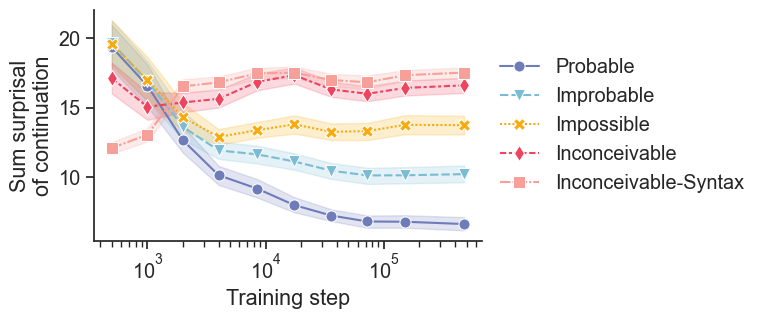

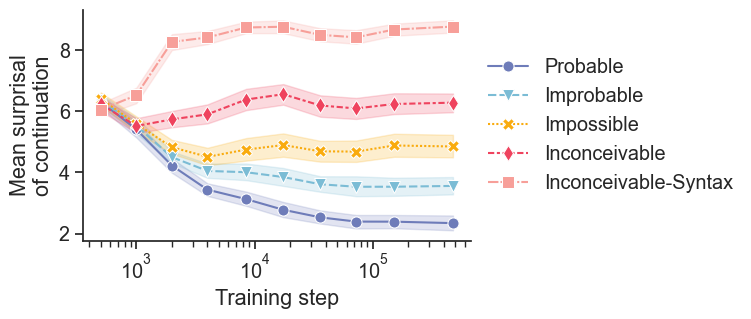

<Figure size 640x480 with 0 Axes>

In [10]:
def plot_surprisal_over_training_time(df, metric="sum"):
    # Add surprisal metric.
    df[f"continuation_{metric}_surprisal"] = -1 * df[f"continuation_{metric}_logprob"]
    ax = sns.lineplot(
        data=df,
        x="step",
        y=f"continuation_{metric}_surprisal",
        hue="condition",
        hue_order=CONDS,
        palette=COND_PAL,
        style="condition",
        markers=["o", "v", "X", "d", "s"],
        markersize=8
    )
    ax.set_xlabel("Training step")
    ax.set_ylabel(f"{metric.capitalize()} surprisal\nof continuation")
    ax.set_xscale("log")
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles,
        labels=[PRETTY_COND_MAP[c] for c in CONDS],
        loc="center left", bbox_to_anchor=(1, 0.5), frameon=False
    )
    sns.despine()
    plt.gcf().set_size_inches(5,3)

for metric in ["sum", "mean"]:
    plot_surprisal_over_training_time(olmo_df, metric=metric)
    render(f"exp2_training_surprisal_{metric}.pdf")
    plt.show()
    plt.clf()

## Item-level analyses

/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_21327/1978378734.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_21327/1978378734.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_21327/1978378734.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_21327/1978378734.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_21327/1978378734.py:33: PerformanceWarning: indexing past lexsort dep

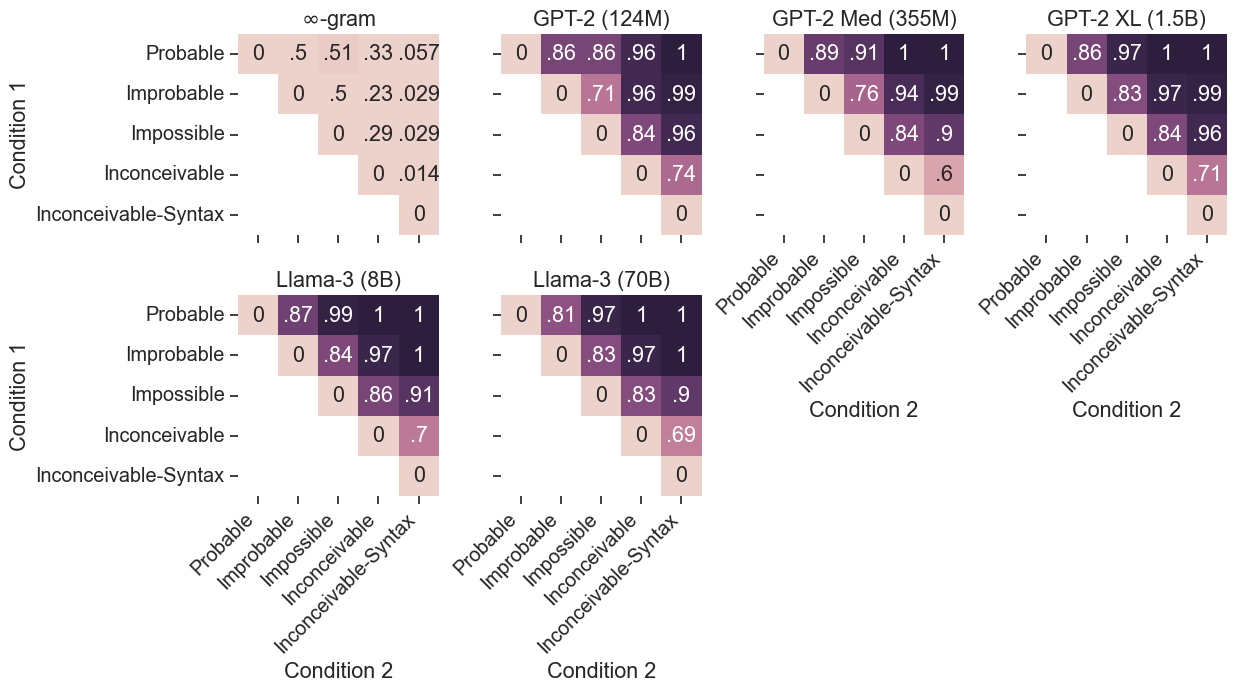

In [10]:
def compute_item_level_scores(df):
    data = []
    for model in df.model.unique():
        m_df = df[df.model==model].set_index(["item_id"])
        for item in m_df.index.unique():
            rows = m_df.loc[item].set_index("condition")
            # Get all combinations of condition pairs.
            for cond1, cond2 in itertools.product(df.condition.unique(), repeat=2):
                res = {"item_id": item, "model": model, "cond1": cond1, "cond2": cond2}
                cond1_label = PRETTY_COND_MAP[cond1]
                cond2_label = PRETTY_COND_MAP[cond2]
                res["cond1_label"] = cond1_label
                res["cond2_label"] = cond2_label
                comparison_name = f"{cond1_label} < {cond2_label}"
                comparison_val = (
                    rows.loc[cond1].continuation_sum_surprisal < 
                    rows.loc[cond2].continuation_sum_surprisal
                )
                res["comparison"] = comparison_name
                res["comparison_outcome"] = comparison_val
                data.append(res)
    data = pd.DataFrame(data)
    return data

def get_heatmap_data(df):
    mats = {}
    for model in df.model.unique():
        m_df = df[df.model==model].set_index(["cond1", "cond2"])
        n_conds = len(CONDS)
        mat = np.zeros((n_conds, n_conds))
        for i, cond1 in enumerate(CONDS):
            for j, cond2 in enumerate(CONDS):
                mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
        mats[model] = mat
    return mats

within_item_comparison = compute_item_level_scores(full_model_df)
heatmap_data = get_heatmap_data(within_item_comparison)

fig, axes = plt.subplots(nrows=2, ncols=4, sharey=False, sharex=False)

for flat_idx, model in enumerate(MODELS):
    i, j = np.unravel_index(flat_idx, (2,4))
    ax = axes[i][j]
    mat = heatmap_data[model]
    # Manually tweaked annotations.
    annot = []
    for row in mat:
        annot_row = []
        for x in row:
            s = f"{x:.2g}"
            if s.startswith("0."):
                s = s.replace("0.", ".")
            annot_row.append(s)
        annot.append(annot_row)
    pal = sns.cubehelix_palette(as_cmap=True)
    mask = np.tril(np.ones_like(mat))
    np.fill_diagonal(mask, False)
    ax = sns.heatmap(
        ax=ax,
        data=mat,
        mask=mask,
        vmin=0.5, 
        vmax=1, 
        cmap=pal, 
        annot=annot, 
        fmt="", 
        cbar=False, 
        square=True
    )
    ax.set_title(PRETTY_MODELS[flat_idx])
    ax.set_xticks([0.5+x for x in range(len(PRETTY_CONDS))])
    if i == 1 or (i==0 and j>1):
        ax.set_xticklabels(PRETTY_CONDS, rotation=45, ha="right")
        ax.set_xlabel("Condition 2")
    else:
        ax.set_xticklabels([])
    if j == 0:
        ax.set_yticklabels(PRETTY_CONDS, rotation=0)
        ax.set_ylabel("Condition 1")
    else:
        ax.set_yticklabels([])
        
axes[1][2].set_visible(False)
axes[1][3].set_visible(False)

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.gcf().set_size_inches(13,6)
render("exp2_item_level_surprisal_comparison_heatmap.pdf")

# Experiment 3: Measuring the effort of modal judgments

In [13]:
# def is_correct(response, condition):
#     condition_coarse = condition.split("_")[0]
#     if condition_coarse in ["probable", "improbable"] and response == 1:
#         return True
#     elif condition_coarse in ["impossible", "inconceivable"] and response == 0:
#         return True
#     else:
#         return False

# exp3 = pd.read_csv("../data/exp3_human_rt/critical.csv")
# exp3["response_correct"] = exp3.apply(
#     lambda r: is_correct(r.response, r.condition),
#     axis=1
# )
# print(f"Experiment 3: {exp3.subject_id.nunique()} unique subjects")
# exp3_practice = pd.read_csv("../data/exp3_human_rt/practice.csv")

In [14]:
# def remove_outliers(df, col, method="zscore"):
#     if method == "zscore":
#         mask = (np.abs(stats.zscore(df[col])) < 2)
#         df = df[mask]
#         return df
#     elif method == "iqr":
#         iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
#         low = df[col].quantile(0.25) - 1.5*iqr
#         high = df[col].quantile(0.75) + 1.5*iqr
#         return df[(df[col]>=low)&(df[col]<=high)]
#     else:
#         raise ValueError("Method should be 'zscore' or 'iqr'")

# def exclude_participants(df, practice_data, accuracy_threshold=0.8, comprehension_threshold=3):
#     # Only keep people above a certain threshold of accuracy.
#     orig_num_participants = df.subject_id.nunique()
#     subj_acc = df.groupby("subject_id").response_correct.mean()
#     subj_to_keep = subj_acc[subj_acc >= accuracy_threshold].index
#     excluded_num_participants = orig_num_participants - len(subj_to_keep)
#     excluded_prop_participants = excluded_num_participants / orig_num_participants
#     print(
#         "Accuracy:",
#         f"Excluded {excluded_num_participants} / {orig_num_participants} ({excluded_prop_participants:.3f})")
#     df = df[df.subject_id.isin(subj_to_keep)]
    
#     # Only keep people with reasonable variance in RT.
#     subj_rt_std = df.groupby("subject_id").rt.std()
#     subj_rt_std_no_outliers = remove_outliers(subj_rt_std.reset_index(), "rt")
#     subj_to_keep = subj_rt_std_no_outliers.subject_id
#     excluded_num_participants = orig_num_participants - len(subj_to_keep)
#     excluded_prop_participants = excluded_num_participants / orig_num_participants
#     print(
#         "Response time variation:",
#         f"Excluded {excluded_num_participants} / {orig_num_participants} ({excluded_prop_participants:.3f})")
#     df = df[df.subject_id.isin(subj_to_keep)]

#     # Only keep people who passed the comp check within 3 attempts.
#     num_comp_attempts = practice_data.groupby("subject_id").attempts.max()
#     subj_to_keep = num_comp_attempts[num_comp_attempts <= comprehension_threshold].index
#     excluded_num_participants = orig_num_participants - len(subj_to_keep)
#     excluded_prop_participants = excluded_num_participants / orig_num_participants
#     print(
#         "Comprehension check:",
#         f"Excluded {excluded_num_participants} / {orig_num_participants} ({excluded_prop_participants:.3f})")
#     df = df[df.subject_id.isin(subj_to_keep)]
    
#     print("Final total number of participants:", df.subject_id.nunique())
#     return df

# exp3_clean = exclude_participants(exp3, exp3_practice)

In [15]:
# def remove_rt_outliers_within_participant(df):
#     # Normalize RTS within participant.
#     subj_rt_data = df.groupby("subject_id").rt.describe()
#     df["rt_normalized"] = df.apply(
#         lambda r: (r.rt - subj_rt_data.loc[r.subject_id, "mean"]) / subj_rt_data.loc[r.subject_id, "std"],
#         axis=1
#     )
#     # Remove rows 3 std. dev. away from participant mean.
#     df = df[(df.rt_normalized < 3) & (df.rt_normalized > -3)]
#     return df
    
# exp3_no_rt_outlier = remove_rt_outliers_within_participant(exp3_clean)
# exp3_no_rt_outlier.to_csv("../data/exp3_human_rt/critical_clean.csv", index=False)

## Figure 4

In [16]:
# ax = sns.barplot(
#     data=exp3_no_rt_outlier, 
#     x="condition", 
#     y="rt_normalized", 
#     hue="condition",
#     legend=False,
#     order=CONDS, 
#     palette=COND_PAL,
#     capsize=0.1,
#     err_kws=dict(linewidth=1.5)
# )
# ax.set_xticks(range(len(PRETTY_CONDS)))
# ax.set_xticklabels([c.replace(" ", "\n") for c in PRETTY_CONDS]) # , rotation=25, ha="right")
# ax.set_xlabel("")
# ax.set_ylabel("Response time\n(normalized)")
# ax.axhline(0, linestyle="--", color="k", alpha=0.4)
# ax.text(-0.1, 0.95, "Slower", ha="right", transform=ax.transAxes, color="slategray", fontweight="bold")
# ax.text(-0.1, 0, "Faster", ha="right", transform=ax.transAxes, color="slategray", fontweight="bold")
# arrow_kws = dict(
#     width=0.003, 
#     transform=ax.transAxes, 
#     clip_on=False, 
#     color="slategray", 
#     head_length=0.04, 
#     head_width=0.015
# )
# ax.arrow(-0.14, 0.6, 0, 0.28, **arrow_kws)
# ax.arrow(-0.14, 0.4, 0, -0.28, **arrow_kws)
# plt.gcf().set_size_inches(11,4)
# sns.despine()
# render("fig4_exp3_rt_normalized_means.pdf")

## Figure 5

In [17]:
# def rt_vs_surprisal(model_df, exp3, rt_metric="rt_normalized"):
#     mean_rt = exp3.groupby(["original_item_id", "condition"])[rt_metric].mean()
#     mean_rt = mean_rt.to_frame().reset_index().rename(
#         columns={"original_item_id": "item_id"}
#     ).set_index(["item_id", "condition"])
    
#     fig, axes = plt.subplots(nrows=1, ncols=len(MODELS), sharey=True, sharex=True, figsize=(11,4))
#     for i, ax in enumerate(axes):
#         model = MODELS[i]
#         surp = model_df[model_df.model==model]
#         df = mean_rt.join(surp.set_index(["item_id", "condition"]))
#         ax = sns.scatterplot(
#             data=df,
#             x="continuation_sum_surprisal",
#             y=rt_metric,
#             hue="condition",
#             hue_order=CONDS,
#             palette=COND_PAL,
#             style="condition",
#             style_order=CONDS,
#             s=100,
#             ax=ax
#         )
#         ax = sns.regplot(
#             data=df,
#             x="continuation_sum_surprisal",
#             y=rt_metric,
#             scatter=False,
#             color="k",
#             ax=ax,
#             label="Linear fit"
#         )
#         ax = sns.regplot(
#             data=df,
#             x="continuation_sum_surprisal",
#             y=rt_metric,
#             scatter=False,
#             color="k",
#             ax=ax,
#             order=2,
#             line_kws=dict(linestyle="--"),
#             label="Second-order fit"
#         )
#         r, p = stats.pearsonr(df["continuation_sum_surprisal"], df[rt_metric])
#         print(f"model={model}, r={r}, p={p}")
#         ax.set_title(PRETTY_MODELS[i])
#         sns.despine()
#         if i == 1:
#             ax.set_xlabel("Surprisal of continuation")
#         else:
#             ax.set_xlabel("")
#         if i == 0:
#             if rt_metric == "rt":
#                 ax.set_ylabel("RT (ms)")
#             else:
#                 ax.set_ylabel("RT (normalized)")
#         else:
#             ax.set_ylabel("")
#         if i != 2:
#             ax.get_legend().remove()
#         else:
#             handles, labels = ax.get_legend_handles_labels()
#             labels = [PRETTY_COND_MAP[l].replace(" ", "\n") for l in labels[:-2]] + labels[-2:]
#             ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# rt_vs_surprisal(model_df, exp3_no_rt_outlier)
# plt.subplots_adjust(wspace=0.15)
# render("fig5_exp3_rt_vs_surprisal.pdf")

## Figure 6

In [18]:
# def judgments_vs_surprisal(data, model_df, ax=None, **kwargs):
#     yes_data = data.groupby(["item_id", "condition"]).response.mean().reset_index()
#     yes_data["item_id_cond"] = yes_data.item_id.astype(str) + "_" + yes_data.condition
#     yes_data["surprisal"] = yes_data.apply(
#         lambda r: model_df[(model_df.item_id==r.item_id)&(model_df.condition==r.condition)].continuation_sum_surprisal.item(),
#         axis=1
#     )
#     if ax is None:
#         ax = plt.gca()
#     # Scatterplot the points.
#     ax = sns.scatterplot(
#         data=yes_data,
#         x="surprisal",
#         y="response",
#         ax=ax,
#         hue="condition",
#         palette=COND_PAL,
#         hue_order=CONDS,
#         style="condition",
#         style_order=CONDS,
#         s=100
#     )
#     # Add regression line.
#     ax = sns.regplot(
#         data=yes_data,
#         x="surprisal",
#         y="response",
#         logistic=True,
#         ax=ax,
#         scatter=False,
#         color="k"
#     )
#     return ax

# fig, axes = plt.subplots(nrows=1, ncols=len(MODELS), sharey=True, sharex=True, figsize=(11,4))
# for i, model in enumerate(MODELS):
#     ax = axes[i]
#     ax = judgments_vs_surprisal(
#         exp3_no_rt_outlier, 
#         model_df[model_df.model==model],
#         ax=ax
#     )
#     ax.set_title(PRETTY_MODELS[i])
#     if i == 0:
#         ax.set_ylabel("Proportion responding \"yes\"")
#     else:
#         ax.set_ylabel("")
#     if i == 1:
#         ax.set_xlabel("Surprisal of continuation")
#     else:
#         ax.set_xlabel("")
#     sns.despine()
#     if i != 2:
#         ax.get_legend().remove()
#     else:
#         handles, labels = ax.get_legend_handles_labels()
#         labels = [PRETTY_COND_MAP[l].replace(" ", "\n") for l in labels]
#         ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
# plt.subplots_adjust(wspace=0.15)
# render("fig6_exp3_judgment_vs_surprisal.pdf")